### Backtesting parametric VaR approaches with scaling
This notebook will investigate three different methods of estimating Value-at-Risk with scaling. A portfolio will be constructed constructed with n number of assets and correlations between them, portfolio returns will be simulated and rolling VaR estimates will be evaluated. 

We assume asset prices follow geometric brownian motion and therefore that the log returns of these asset prices are normally distributed. The below code defines three assets with parameters for the mean, standard deviation and correlations for their log returns. The portfolio is then specified using weights for each asset, which represent the portfolio exposure to that asset.

In [290]:
import numpy as np
import pandas as pd
from scipy.stats import norm


n_days = 10_000
mu_log = np.array([0.0, 0.0, 0.0])
std_log = np.array([0.05, 0.07, 0.09]) 
corr_log = np.array([[1.0, 0.8, 0.2],
                    [0.8, 1.0, 0.3],
                    [0.2,0.3, 1.0]])

weights = np.array([50, 50, 50])
w_normalised = weights / np.sum(np.abs(weights))

The function below generates normal_log returns for each asset based on specified volatilities and correlations, converts log returns into simple returns and multiplies by the normalised weights to get the portfolio return for each n_day.

In [291]:
def generate_portfolio_returns(mu_log, std_log, corr_log, w_normalised, n_days):
    cov_log = np.outer(std_log, std_log) * corr_log
    logR = np.random.multivariate_normal(mean=mu_log, cov=cov_log, size=n_days)
    R = np.exp(logR) - 1 
    portfolio_returns = R @ w_normalised
    return logR, R, portfolio_returns

Below we visualise the portfolio return, which is bounded by -1 when all positions in the portfolio are long, and has a right tail which becomes especially visible when volatilities are high. This is a lognormal distribution. When all positions are short, the we get a long left tail instead of right tail.

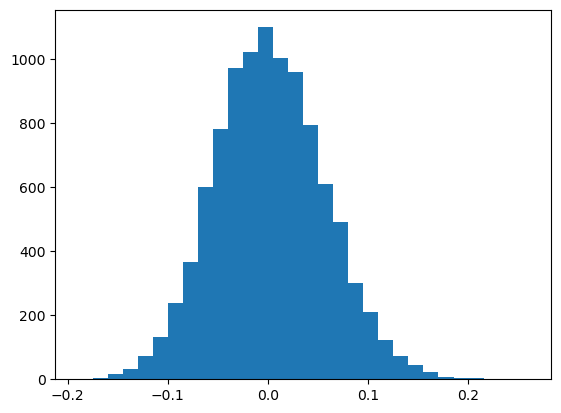

In [292]:
import matplotlib.pyplot as plt
portfolio_returns = generate_portfolio_returns(mu_log, std_log, corr_log, w_normalised, n_days)[2]
plt.hist(portfolio_returns, bins=30)
plt.show()

Below we show the the distribution of the portfolio log return, which is approximately normal. 

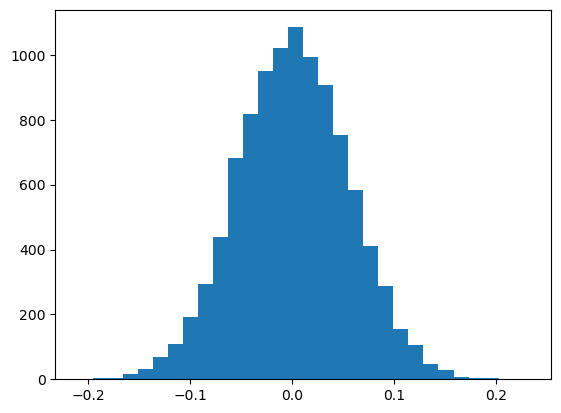

In [293]:
portfolio_log_returns = np.log(1+portfolio_returns)
plt.hist(portfolio_log_returns, bins=30)
plt.show()

Now we will use the returns we have generated to create a function which provides scaled and unscaled rolling VaR estimates under the three different approaches. We will later backtest these VaR estimates. 

In [294]:
def generate_var_estimates (window, n_days, logR, R, Z, holding_period):
    VaR_A, VaR_A_scaled = np.full(n_days, np.nan), np.full(n_days, np.nan)
    VaR_B, VaR_B_scaled = np.full(n_days, np.nan), np.full(n_days, np.nan)
    VaR_C, VaR_C_scaled = np.full(n_days, np.nan), np.full(n_days, np.nan)
    
    for t in range(window, n_days):
        # Approach A: assumes portfolio simple returns are normal (as we have seen, they are not)
        rolling_window = R[t-window:t]
        cov_matrix = np.cov(rolling_window, rowvar=False, ddof=1)
        port_var = np.dot(w_normalised.T, np.dot(cov_matrix, w_normalised))
        port_std = np.sqrt(port_var)
        VaR_A[t] = Z * port_std
        VaR_A_scaled[t] = Z * port_std * np.sqrt(holding_period)
        
        # Approach B: assumes portfolio log returns are normal (as they are)
        rolling_window = logR[t-window:t]
        cov_matrix = np.cov(rolling_window, rowvar=False, ddof=1)
        port_var = np.dot(w_normalised.T, np.dot(cov_matrix, w_normalised))
        port_std = np.sqrt(port_var)
        VaR_B[t] = np.exp(Z * port_std) - 1
        VaR_B_scaled[t] = np.exp(Z * port_std *np.sqrt(holding_period)) - 1
        
        #Approach C: assumes portfolio log returns are normal, returns 1% quantile in log return space
        VaR_C[t] = Z * port_std
        VaR_C_scaled[t] = Z * port_std * np.sqrt(holding_period)
    
    VaR_df= pd.DataFrame({
        "simple_normal": VaR_A,
        "simple_normal_scaled": VaR_A_scaled,
        "lognormal": VaR_B,
        "lognormal_scaled": VaR_B_scaled,
        "normal_on_log": VaR_C,
        "normal_on_log_scaled": VaR_C_scaled
    })
    
    return VaR_df

We can now generate our VaR estimates. We define a a rolling window, a confidence level and holding period, then run the functions we have defined to obtain our VaR dataframe. We can then plot the VaR_estimates for each approach against actual returns. Lets look at the unscaled version first. 

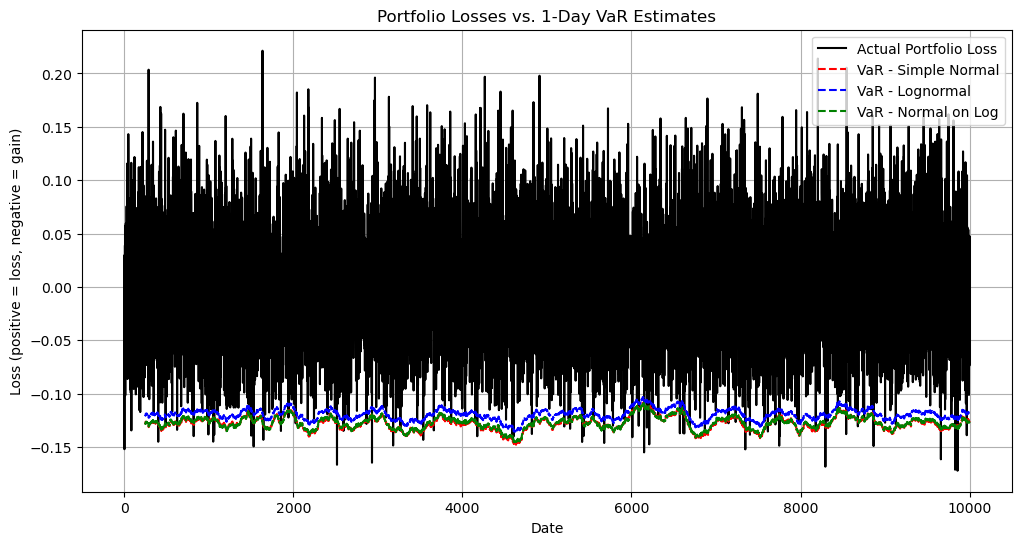

In [295]:
window=250
Z = norm.ppf(0.01)
holding_period = 10

logR, R, portfolio_returns = generate_portfolio_returns(mu_log, std_log, corr_log, w_normalised, n_days)
VaR_df = generate_var_estimates(window, n_days, logR, R, Z, holding_period)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns, color="black", label="Actual Portfolio Loss")

plt.plot(VaR_df["simple_normal"], "--", color="red", label="VaR - Simple Normal")
plt.plot(VaR_df["lognormal"], "--", color="blue", label="VaR - Lognormal")
plt.plot(VaR_df["normal_on_log"], "--", color="green", label="VaR - Normal on Log")

plt.title("Portfolio Losses vs. 1-Day VaR Estimates")
plt.xlabel("Date")
plt.ylabel("Loss (positive = loss, negative = gain)")
plt.legend()
plt.grid(True)
plt.show()

We can see that for 1-Day VaR estimates, the three different approaches are very similar. To get a better view of the differences we can count the number of breaches by checking on how many days the portfolio return was lower than the VaR estimate for that day. Since we have 9750 VaR estimates, the expected number of breaches in 97.5

In [296]:
exceed_A = (portfolio_returns) < VaR_df["simple_normal"]
exceed_B = (portfolio_returns) < VaR_df["lognormal"]
exceed_C = (portfolio_returns) < VaR_df["normal_on_log"]

backtest_results = pd.DataFrame({
    "VaR breaches": [
        exceed_A.sum(),
        exceed_B.sum(),
        exceed_C.sum()
    ],
        "Expected breaches": [
        (n_days - window) * 0.01,
        (n_days - window) * 0.01,
        (n_days - window) * 0.01
    ]
}, index=["Approach A (normal simple)", "Approach B (lognormal)", "Approach C (normal log)"])
print(backtest_results)

                            VaR breaches  Expected breaches
Approach A (normal simple)            59               97.5
Approach B (lognormal)                88               97.5
Approach C (normal log)               61               97.5


Nows let's look at at the scaled case. In this case we need to compare the VaR estimate on each day with the 10-day portfolio return, including that day.

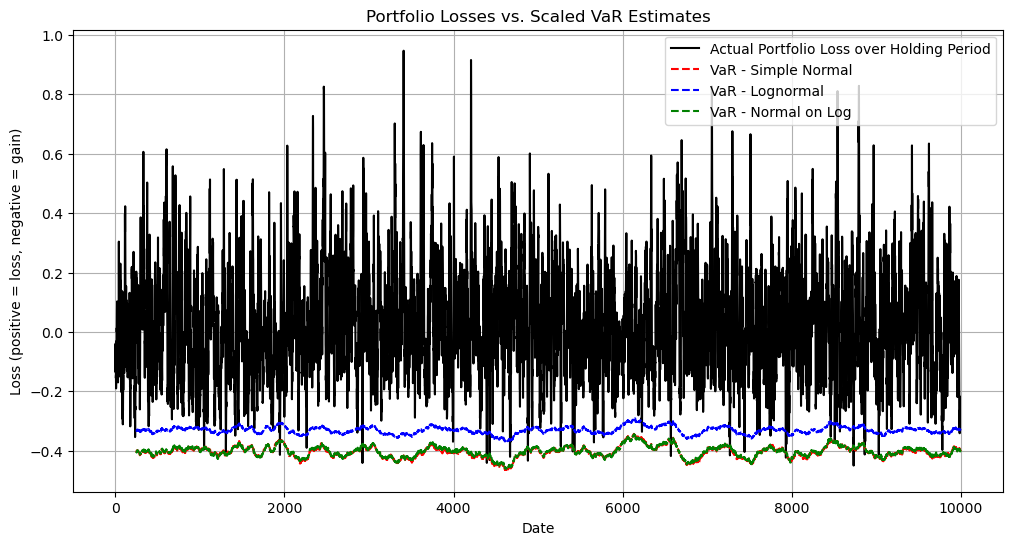

In [297]:
fwd_returns = np.array([
    np.prod(1 + portfolio_returns[t:t+holding_period]) - 1
    for t in range(len(portfolio_returns) - holding_period)
])

plt.figure(figsize=(12, 6))
plt.plot(fwd_returns, color="black", label="Actual Portfolio Loss over Holding Period")

plt.plot(VaR_df["simple_normal_scaled"], "--", color="red", label="VaR - Simple Normal")
plt.plot(VaR_df["lognormal_scaled"], "--", color="blue", label="VaR - Lognormal")
plt.plot(VaR_df["normal_on_log_scaled"], "--", color="green", label="VaR - Normal on Log")

plt.title("Portfolio Losses vs. Scaled VaR Estimates")
plt.xlabel("Date")
plt.ylabel("Loss (positive = loss, negative = gain)")
plt.legend()
plt.grid(True)
plt.show()

This time, we can see a little bit more difference. The lognormal approach is a little less conservative than the two other approaches. Again we can count breaches. This time we have (n_days-holding_period) portfolio returns, so the expected number of breaches is (n_days-window-holding_period) * 0.01. The result shows that the lognormal approach is much closer to the expected number of breaches than the two other approaches. 

In [298]:
fwd_returns = pd.Series(fwd_returns)
VaR_df_valid = VaR_df.iloc[:len(fwd_returns)]

exceed_A_scaled = fwd_returns < VaR_df_valid["simple_normal_scaled"]
exceed_B_scaled = fwd_returns < VaR_df_valid["lognormal_scaled"]
exceed_C_scaled = fwd_returns < VaR_df_valid["normal_on_log_scaled"]

backtest_scaled = pd.DataFrame({
    "VaR breaches": [
        exceed_A_scaled.sum(),
        exceed_B_scaled.sum(),
        exceed_C_scaled.sum()
    ],
    "Expected breaches": [
        (n_days - window - holding_period) * 0.01,
        (n_days - window - holding_period) * 0.01,
        (n_days - window - holding_period) * 0.01
    ]
}, index=["Approach A scaled (normal simple)", "Approach B scaled (lognormal)", "Approach C scaled (normal-on-log)"])
print(backtest_scaled)

                                   VaR breaches  Expected breaches
Approach A scaled (normal simple)            20               97.4
Approach B scaled (lognormal)               114               97.4
Approach C scaled (normal-on-log)            21               97.4


We can make the backtest more robust by performing a Kupiec backtest which checks to see if the number of breaches matches the chosen confidence level. 

In [302]:
from scipy.stats import chi2

def kupiec_test(num_exceed, num_obs, p):
    """Kupiec proportion-of-failures (POF) test"""
    if num_exceed == 0 or num_exceed == num_obs:
        return np.nan  # avoids log(0)
    phat = num_exceed / num_obs
    LR_uc = -2 * (
        (num_obs - num_exceed) * np.log((1 - p) / (1 - phat))
        + num_exceed * np.log(p / phat)
    )
    p_value = 1 - chi2.cdf(LR_uc, df=1)
    return p_value

Now we can revisit the unscaled approach and check Kupiec p-values. Typically, a p-value below 0.05 means we can reject the VaR model.

In [303]:
pd.set_option("display.max_columns", None)   
pd.set_option("display.width", None)

p = 0.01
num_obs = n_days - window
expected_breaches = num_obs * p

backtest_results = pd.DataFrame({
    "VaR breaches": [
        exceed_A.sum(),
        exceed_B.sum(),
        exceed_C.sum()
    ],
    "Expected breaches": [
        expected_breaches,
        expected_breaches,
        expected_breaches
    ]
}, index=[
    "Approach A (normal simple)",
    "Approach B (lognormal)",
    "Approach C (normal log)"
])

# Apply Kupiec test
backtest_results["Kupiec p-value"] = [
    kupiec_test(exceed_A.sum(), num_obs, p),
    kupiec_test(exceed_B.sum(), num_obs, p),
    kupiec_test(exceed_C.sum(), num_obs, p)
]

print(backtest_results)

                            VaR breaches  Expected breaches  Kupiec p-value
Approach A (normal simple)            59               97.5        0.000024
Approach B (lognormal)                88               97.5        0.325528
Approach C (normal log)               61               97.5        0.000066


If we want to use kupiec p-values appropriately in the scaled version we need to non-overlapping holding_period returns to ensure independent test observations. Again, lognormal comes out as the best approach. 

In [306]:
# For 10000 daily returns, this gives 10000 / 10 = 1000 10-day blocks
n_blocks = len(portfolio_returns) // holding_period

fwd_returns = np.array([
    np.prod(1 + portfolio_returns[i*holding_period:(i+1)*holding_period]) - 1
    for i in range(n_blocks)
])
fwd_returns = pd.Series(fwd_returns)

# Align VaR with these non-overlapping periods
VaR_df_valid = VaR_df.iloc[:len(fwd_returns)]


# --- Identify breaches for each VaR approach ---
exceed_A_scaled = fwd_returns < VaR_df_valid["simple_normal_scaled"]
exceed_B_scaled = fwd_returns < VaR_df_valid["lognormal_scaled"]
exceed_C_scaled = fwd_returns < VaR_df_valid["normal_on_log_scaled"]


# --- Compute statistics ---
p = 0.01  # tail probability for 99% VaR
num_obs = len(fwd_returns)
expected_breaches = num_obs * p

backtest_scaled = pd.DataFrame({
    "VaR breaches": [
        exceed_A_scaled.sum(),
        exceed_B_scaled.sum(),
        exceed_C_scaled.sum()
    ],
    "Expected breaches": [
        expected_breaches,
        expected_breaches,
        expected_breaches
    ],
    "Kupiec p-value": [
        kupiec_test(exceed_A_scaled.sum(), num_obs, p),
        kupiec_test(exceed_B_scaled.sum(), num_obs, p),
        kupiec_test(exceed_C_scaled.sum(), num_obs, p)
    ]
}, index=[
    "Approach A scaled (normal simple)",
    "Approach B scaled (lognormal)",
    "Approach C scaled (normal-on-log)"
])

pd.set_option("display.float_format", "{:.3f}".format)
print("\n 10-Day Non-Overlapping Scaled VaR Backtest:")
print(backtest_scaled.to_string())


 10-Day Non-Overlapping Scaled VaR Backtest:
                                   VaR breaches  Expected breaches  Kupiec p-value
Approach A scaled (normal simple)             4             10.000           0.030
Approach B scaled (lognormal)                14             10.000           0.231
Approach C scaled (normal-on-log)             5             10.000           0.079
